In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import glob
import pickle
import shutil
from pathlib import Path
import sys
sys.path.append('/storage3/eva/code/neuropixels/src')
import path_formatting as pf
import oe
import motive

In [57]:
date = "20250909"
animal = "eb03"
oe_sr = 30000 # ephys sampling rate 30kHz
m_sr = 120 # motive sampling rate 120Hz

# ephys
dat_path = rf'X:\eva\data\raw\oe\{animal}\{animal}_{date}\continuous.dat'
dat_path = pf.w2l(dat_path)

ks_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\kilosort'
ks_path = pf.w2l(ks_path)

# motive
csv_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\motive\out_csv'
csv_path = pf.w2l(csv_path)

# output
res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
os.makedirs(res_path, exist_ok=True) # Create the folder if it doesn't exist

dat_path, ks_path, csv_path, res_path

('/storage3/eva/data/raw/oe/eb03/eb03_20250909/continuous.dat',
 '/storage3/eva/data/processed/eb03/eb03_20250909/kilosort',
 '/storage3/eva/data/processed/eb03/eb03_20250909/motive/out_csv',
 '/storage3/eva/code/neuropixels/results/eb03/eb03_20250909')

In [58]:
csv_dict = motive.get_csv_dict(csv_path)
motive_keys = list(csv_dict.keys())
motive_keys

['20250909_1', '20250909_2', '20250909_3']

sec: 1803.832645 min: 30.063877416666667
{'Format Version': '1.21', 'Take Name': 'Take 2025-09-09 11.59.09 AM', 'Capture Frame Rate': '120.000046', 'Export Frame Rate': '120.000046', 'Capture Start Time': '2025-09-09 11.59.09.197 AM', 'Total Frames in Take': '216461', 'Total Exported Frames': '216461', 'Rotation Type': 'Quaternion', 'Length Units': 'Meters', 'Coordinate Space': 'Global', 'Duration': 1803.832645} 
 ------------------------------------------------------------------
isna False | nan_count 0
min frame duration 0.008334000000104425 s
max frame duration 0.008332999999993262 s
diff 1.0000001111620804 μs


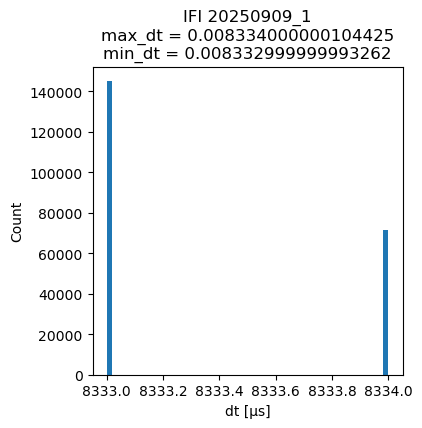

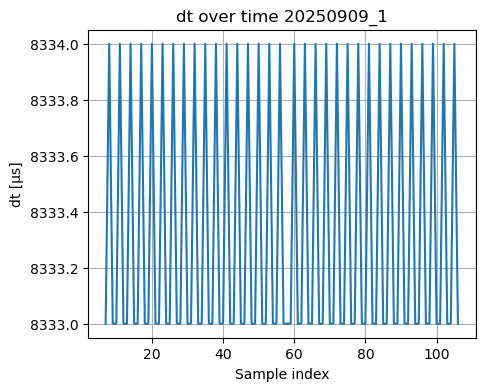

X : 1203 lost frames
Y : 1203 lost frames
Z : 1203 lost frames


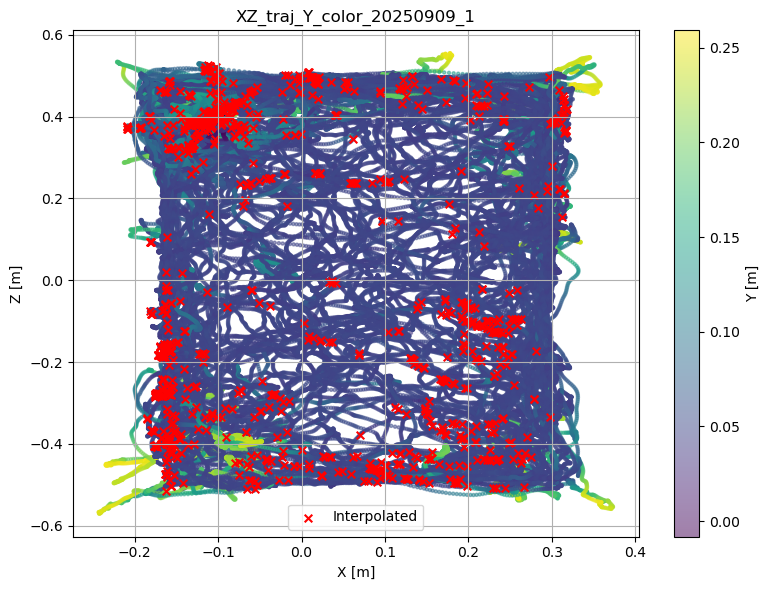

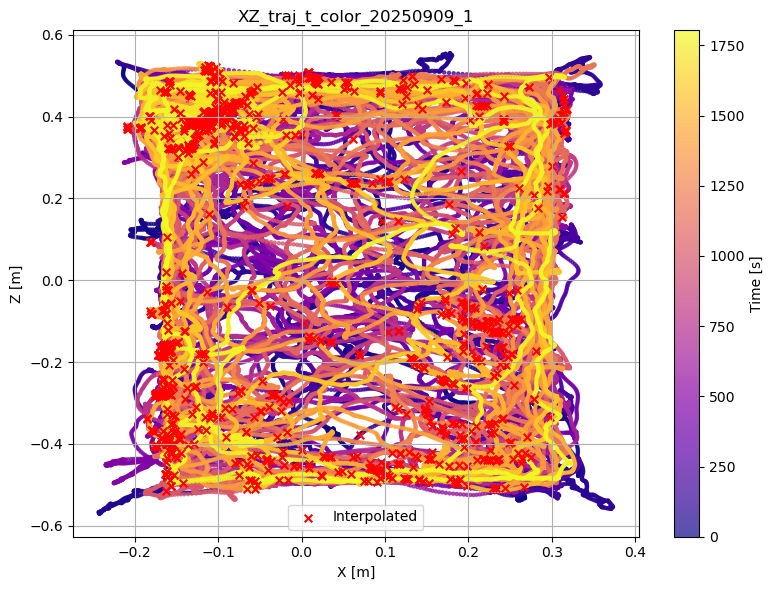

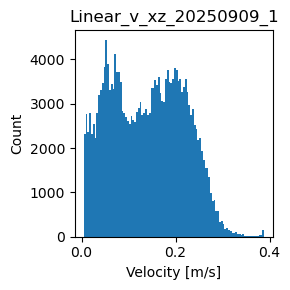

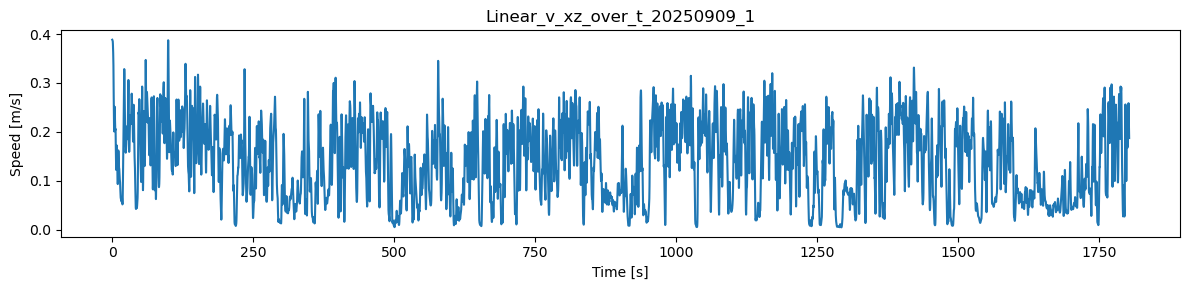

/tmp/ipykernel_4088/3031999624.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


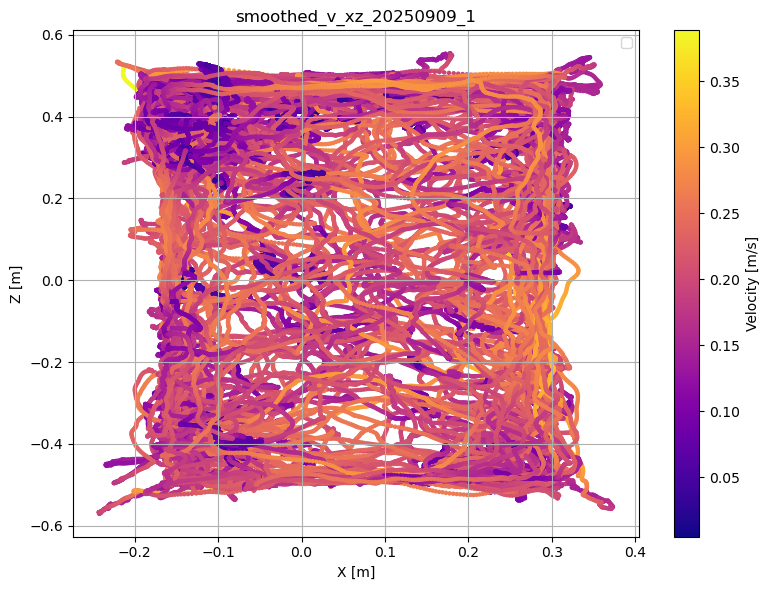

sec: 1800.86598 min: 30.014433
{'Format Version': '1.21', 'Take Name': 'Take 2025-09-09 01.09.37 PM', 'Capture Frame Rate': '120.000046', 'Export Frame Rate': '120.000046', 'Capture Start Time': '2025-09-09 01.09.37.254 PM', 'Total Frames in Take': '216105', 'Total Exported Frames': '216105', 'Rotation Type': 'Quaternion', 'Length Units': 'Meters', 'Coordinate Space': 'Global', 'Duration': 1800.86598} 
 ------------------------------------------------------------------
isna False | nan_count 0
min frame duration 0.008334000000104425 s
max frame duration 0.008332999999993262 s
diff 1.0000001111620804 μs


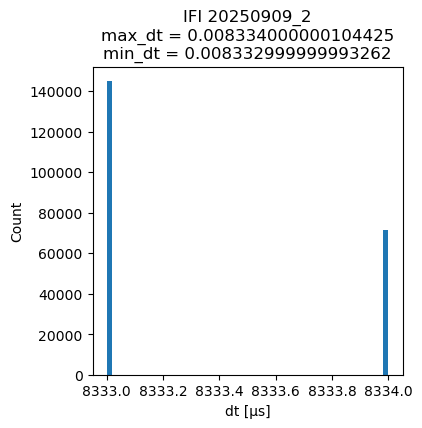

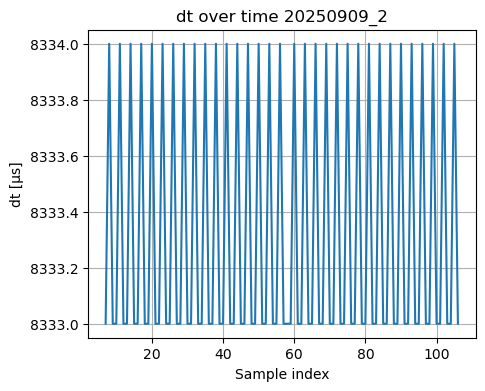

X : 3225 lost frames
Y : 3225 lost frames
Z : 3225 lost frames


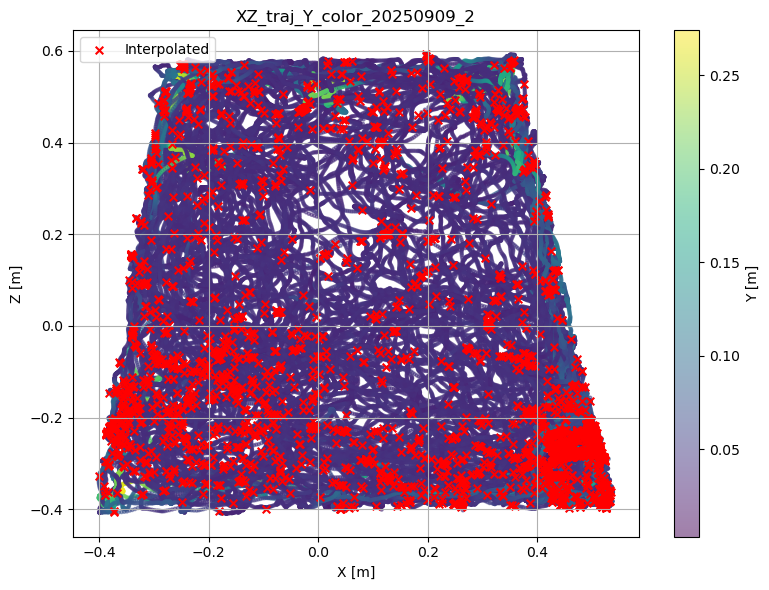

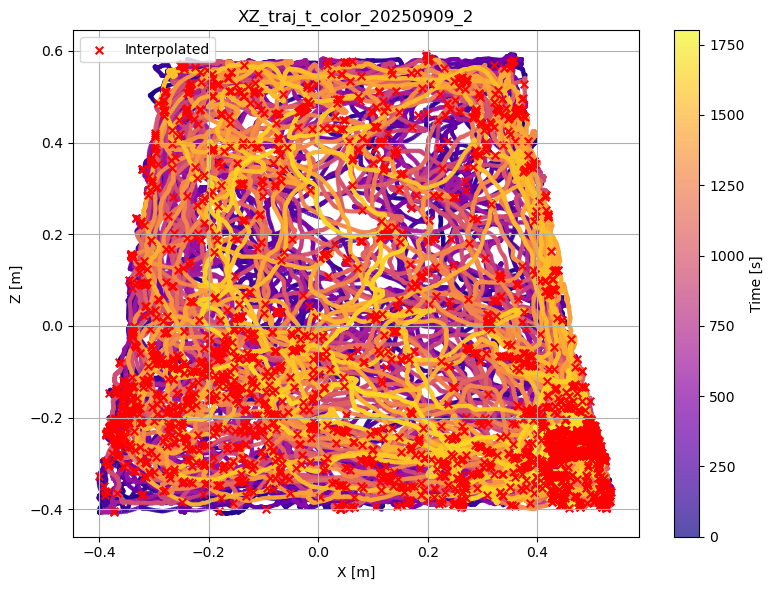

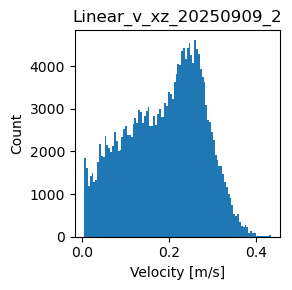

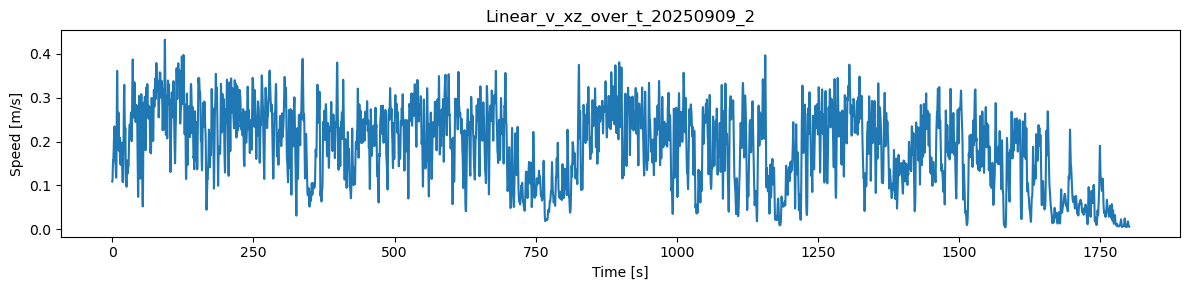

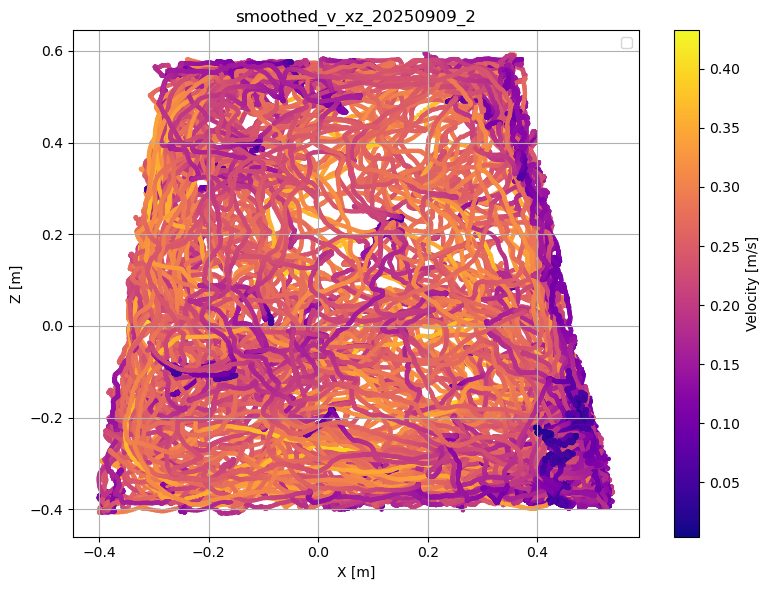

sec: 1659.324367 min: 27.655406116666665
{'Format Version': '1.21', 'Take Name': 'Take 2025-09-09 02.21.46 PM', 'Capture Frame Rate': '120.000046', 'Export Frame Rate': '120.000046', 'Capture Start Time': '2025-09-09 02.21.46.692 PM', 'Total Frames in Take': '199120', 'Total Exported Frames': '199120', 'Rotation Type': 'Quaternion', 'Length Units': 'Meters', 'Coordinate Space': 'Global', 'Duration': 1659.324367} 
 ------------------------------------------------------------------
isna False | nan_count 0
min frame duration 0.008334000000104425 s
max frame duration 0.008332999999993262 s
diff 1.0000001111620804 μs


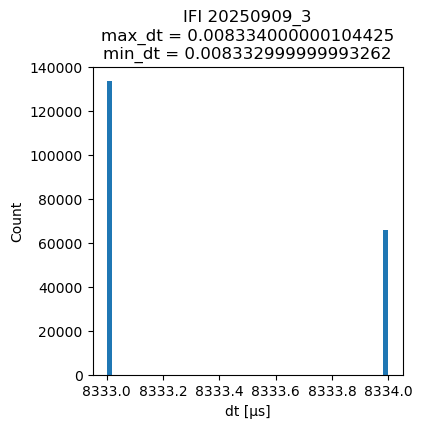

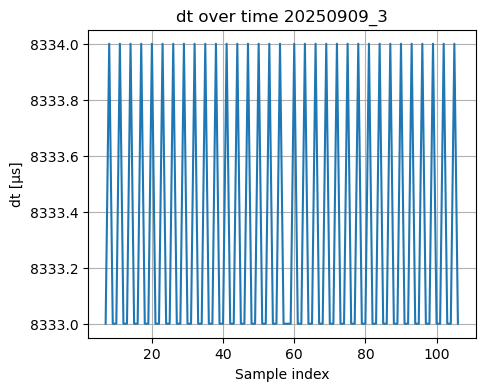

X : 1253 lost frames
Y : 1253 lost frames
Z : 1253 lost frames


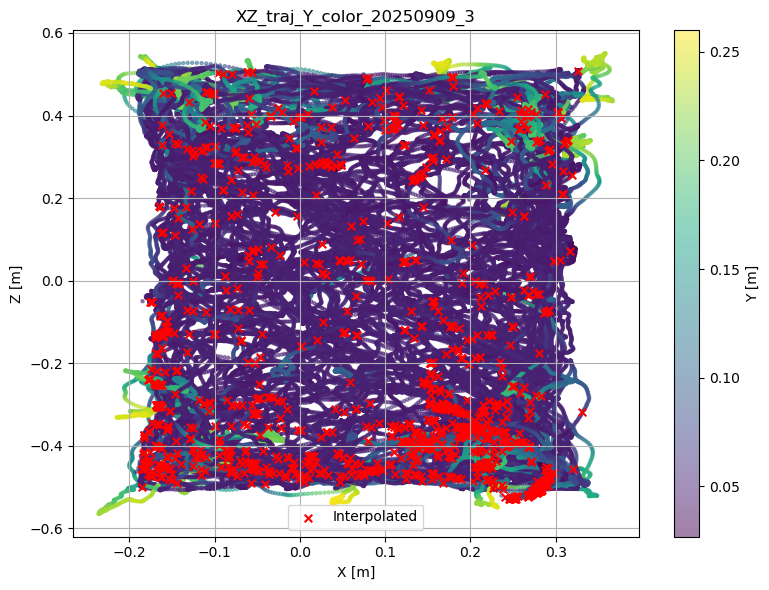

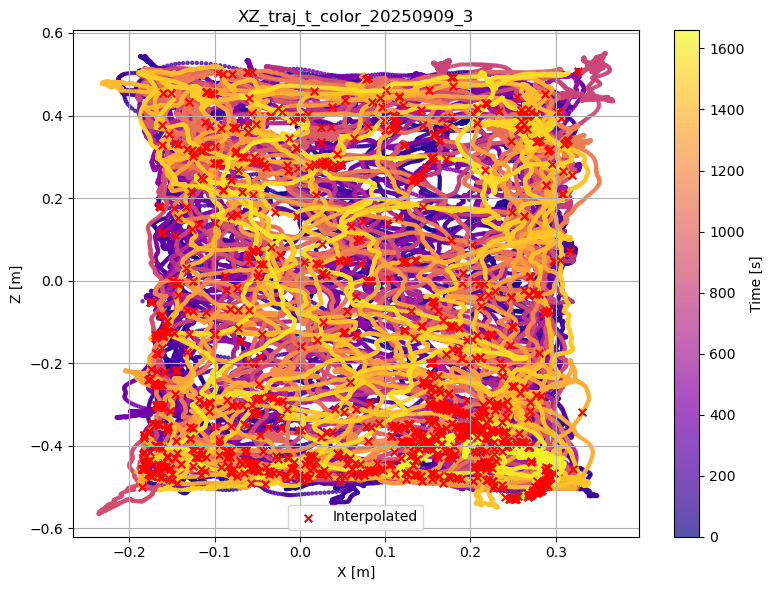

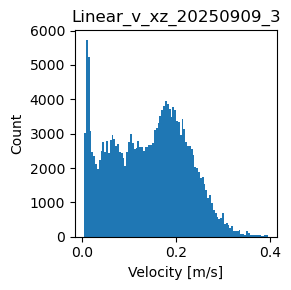

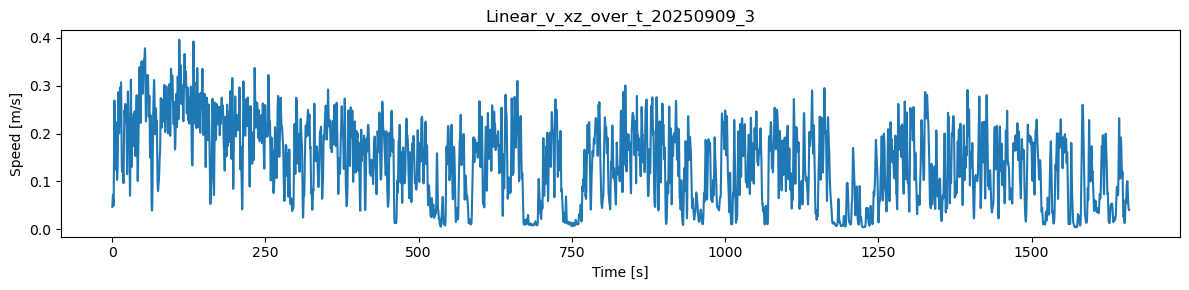

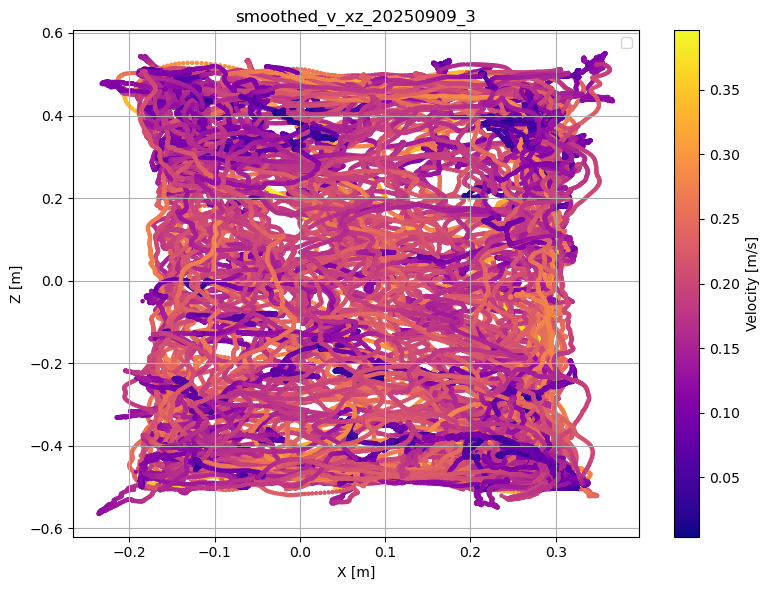

In [60]:
for trial in motive_keys:
    try:
        # load df
        df = csv_dict[trial]

        # show meta
        motive_meta = df.iloc[0, 0:20].tolist()
        motive_meta = {motive_meta[i]: motive_meta[i + 1] for i in range(0, len(motive_meta) - 1, 2)}
        trial_duration = float(df.iloc[-1, 1])
        motive_meta['Duration'] = trial_duration
        print('sec:',trial_duration,'min:',trial_duration/60)
        file_path = res_path+"/motive_meta.txt"
        entry = f"\n--- {trial} ---\n"
        for key, value in motive_meta.items():
            entry += f"{key}: {value}\n"
        with open(file_path, 'a') as f:
            f.write(entry)
        print(motive_meta, '\n', '------------------------------------------------------------------')

        # checking frame_times
        try:
            i=6
            frame_times = df.iloc[i:, 1] 
            print('isna', frame_times.isna().any(), '| nan_count', frame_times.isna().sum())
            frame_times = pd.to_numeric(frame_times, errors='coerce').dropna()
            dt = frame_times.diff().dropna()
            print(f'min frame duration {np.max(dt)} s\nmax frame duration {np.min(dt)} s\ndiff {(np.max(dt)-np.min(dt))*1000*1000} μs')
            frame_times = frame_times.to_numpy()
        except:
            i=7
            frame_times = df.iloc[i:, 1] 
            print('isna', frame_times.isna().any(), '| nan_count', frame_times.isna().sum())
            frame_times = pd.to_numeric(frame_times, errors='coerce').dropna()
            dt = frame_times.diff().dropna()
            print(f'min frame duration {np.max(dt)} s\nmax frame duration {np.min(dt)} s\ndiff {(np.max(dt)-np.min(dt))*1000*1000} μs')
            frame_times = frame_times.to_numpy()

        plt.figure(figsize=(4,4))
        plt.hist(dt*1e6, bins=50) # 1e6 = 10**6 = microsec
        plt.xlabel('dt [μs]')
        plt.ylabel('Count')
        plt.title(f'IFI {trial}\nmax_dt = {np.max(dt)}\nmin_dt = {np.min(dt)}')
        filename = f'IFI_{trial}'
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(5,4))
        plt.plot(dt[:100]*1e6)
        plt.xlabel("Sample index")
        plt.ylabel("dt [μs]")
        plt.title(f"dt over time {trial}")
        plt.grid(True)
        filename = f't_dt_{trial}'
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show()

        # markers quality check
        arrays, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
        for key in arrays.keys():
            print(key, ':', np.isnan(arrays[key]).sum(), 'lost frames')
        # assuming that loss coincides
        nan_mask = np.isnan(arrays['X']) | np.isnan(arrays['Y']) | np.isnan(arrays['Z'])
        valid_mask = ~nan_mask
        x = arrays_interpol['X']
        y = arrays_interpol['Y']
        z = arrays_interpol['Z']  
        # y colored plot
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(x[valid_mask], z[valid_mask], c=y[valid_mask], cmap='viridis', s=5, alpha=0.5)    
        plt.scatter(x[nan_mask], z[nan_mask], c='red', s=30, label='Interpolated', marker='x')
        plt.xlabel("X [m]")
        plt.ylabel("Z [m]")
        filename = f'XZ_traj_Y_color_{trial}'
        plt.title(filename)
        plt.colorbar(sc, label='Y [m]')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show()
        # time colored plot
        t = motive.get_frame_times(df)
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(x[valid_mask], z[valid_mask], c=t[valid_mask], cmap='plasma', s=5, alpha=0.7)
        plt.scatter(x[nan_mask], z[nan_mask], color='red', s=30, marker='x', label='Interpolated')
        plt.xlabel("X [m]")
        plt.ylabel("Z [m]")
        filename = f'XZ_traj_t_color_{trial}'
        plt.title(filename)
        plt.colorbar(sc, label='Time [s]')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show() 
        
        # speed analysis
        _,_,v = motive.speed(x, z, t) # smoothed
        plt.figure(figsize=(3,3))
        plt.hist(v, bins=100)
        plt.xlabel("Velocity [m/s]")
        plt.ylabel("Count")
        filename = f'Linear_v_xz_{trial}'
        plt.title(filename)
        plt.tight_layout()
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show() 

        plt.figure(figsize=(12, 3))
        plt.plot(t, v)
        plt.xlabel("Time [s]")
        plt.ylabel("Speed [m/s]")
        filename = f'Linear_v_xz_over_t_{trial}'
        plt.title(filename)
        plt.tight_layout()
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show()


        plt.figure(figsize=(8, 6))
        sc = plt.scatter(x, z, c=v, cmap='plasma', s=5)
        plt.xlabel('X [m]')
        plt.ylabel('Z [m]')
        filename = f'smoothed_v_xz_{trial}'
        plt.title(filename)
        plt.colorbar(sc, label='Velocity [m/s]')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
        plt.show()
    except:
        continue


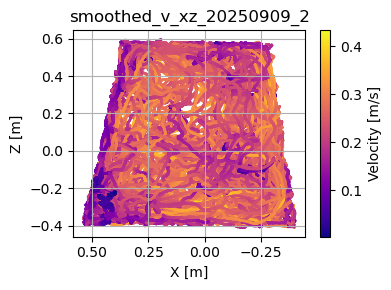

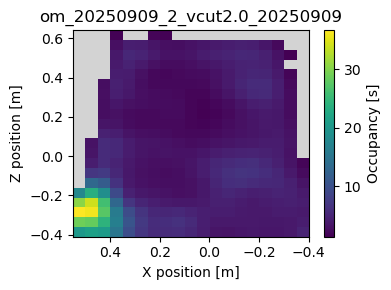

In [74]:
i=1
fs = (4,3) # (3,4) or (4,3)

df = csv_dict[motive_keys[i]]

t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
z = arrays_interpol['Z']
_,_,v = motive.speed(x, z, t)

speed_cutoff = 0.02 # 2cm/s
movement_mask = v > speed_cutoff 
x_moving = x[movement_mask]
z_moving = z[movement_mask]

bin_size = 0.05
x_edges = np.arange(x.min(), x.max()  + bin_size, bin_size)
z_edges = np.arange(z.min(), z.max()  + bin_size, bin_size)

occupancy_counts, _, _ = np.histogram2d(x_moving, z_moving, bins=[x_edges, z_edges])
occupancy_seconds = occupancy_counts/m_sr
#smooth
from scipy.ndimage import gaussian_filter
sigma = 1.0  # adjust as needed (in bins)
occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)

occupancy_mask = (occupancy_seconds == 0) | (occupancy_smooth < 1.0)
occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)

plt.figure(figsize=fs)
sc = plt.scatter(x, z, c=v, cmap='plasma', s=1)
plt.gca().invert_xaxis() 
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
filename = f'smoothed_v_xz_{motive_keys[i]}'
plt.title(filename)
plt.colorbar(sc, label='Velocity [m/s]')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
plt.show()


import matplotlib.cm as cm
plt.figure(figsize=fs) 
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')  # NaNs will be shown as light grey
plt.imshow(
    occupancy_smooth_masked.T, 
    origin='lower', 
    extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
    aspect='auto',
    cmap=cmap,
)
plt.gca().invert_xaxis() 
plt.colorbar(label='Occupancy [s]')
plt.xlabel('X position [m]')
plt.ylabel('Z position [m]')
filename = f'om_{motive_keys[i]}_vcut{speed_cutoff*100}_{date}'
plt.title(filename)
plt.tight_layout()
plt.show()

In [55]:
motive_keys

['20250909_2', '20250909_4', '20250909_6']

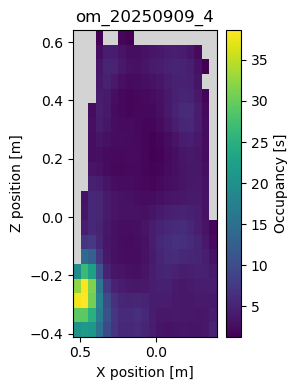

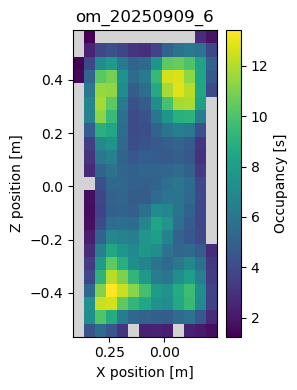

In [56]:
for trial in motive_keys:
    try:
        z_min, z_max = -0.55, 0.5
        z_min, z_max = None, None
        # load df
        df = csv_dict[trial]



        t = motive.get_frame_times(df)
        _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
        x = arrays_interpol['X']
        y = arrays_interpol['Y']
        z = arrays_interpol['Z']

        _,_,v = motive.speed(x, z, t)

        bin_size = 0.05

        x_edges = np.arange(x.min(), x.max()  + bin_size, bin_size)
        z_edges = np.arange(z.min(), z.max()  + bin_size, bin_size)

        occupancy_counts, _, _ = np.histogram2d(x, z, bins=[x_edges, z_edges])
        occupancy_seconds = occupancy_counts/m_sr

        #smooth
        from scipy.ndimage import gaussian_filter
        sigma = 1.0  # adjust as needed (in bins)
        occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)

        occupancy_mask = (occupancy_seconds == 0) #| (occupancy_smooth < 1.0)
        occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)

        import matplotlib.cm as cm
        save=False

        plt.figure(figsize=(3,4))
        cmap = cm.viridis.copy()
        cmap.set_bad(color='lightgrey')  # NaNs will be shown as light grey
        plt.imshow(
            occupancy_smooth_masked.T, 
            origin='lower', 
            extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
            aspect='auto',
            cmap=cmap,
        )
        plt.ylim(z_min, z_max)
        plt.gca().invert_xaxis() 
        plt.colorbar(label='Occupancy [s]')
        plt.xlabel('X position [m]')
        plt.ylabel('Z position [m]')
        filename = f'om_{trial}'
        plt.title(filename)
        plt.tight_layout()

        # if save:
        #     plt.savefig(pf_path / f"{filename}.png", dpi=300, bbox_inches='tight')
        plt.show()
    except:
        continue

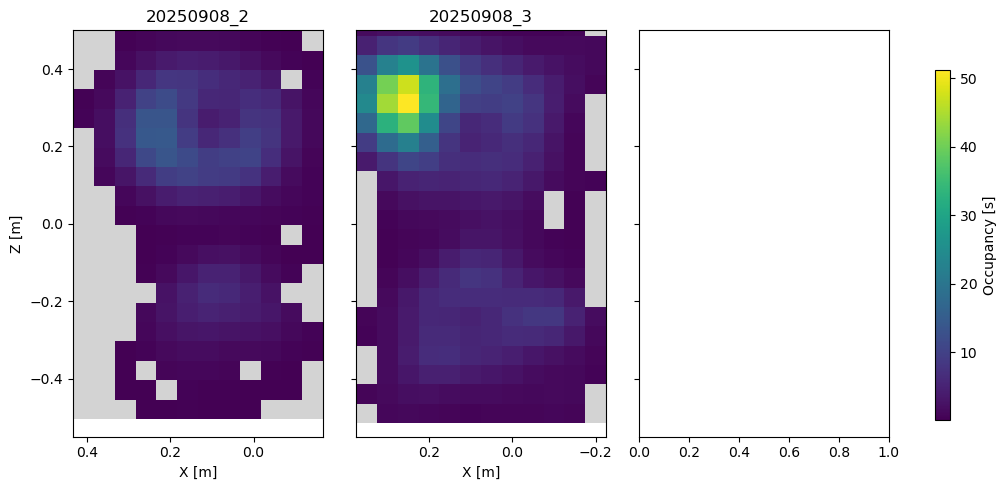

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter
import numpy as np

# Trials you want to plot
trials_to_plot = motive_keys[1:4]  # or ['of1', 'of2', 'of3']

# Pre-set limits
z_min, z_max = -0.55, 0.5
bin_size = 0.05
sigma = 1.0

# First pass: find global vmin/vmax for colorbar scaling
all_data = []
for trial in trials_to_plot:
    df = csv_dict[trial]
    t = motive.get_frame_times(df)
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
    x, z = arrays_interpol['X'], arrays_interpol['Z']
    occupancy_counts, _, _ = np.histogram2d(x, z, bins=[
        np.arange(x.min(), x.max() + bin_size, bin_size),
        np.arange(z.min(), z.max() + bin_size, bin_size),
    ])
    occupancy_seconds = occupancy_counts / m_sr
    smoothed = gaussian_filter(occupancy_seconds, sigma=sigma)
    mask = (occupancy_seconds == 0)
    smoothed_masked = np.where(mask, np.nan, smoothed)
    all_data.append(smoothed_masked)

global_vmin = np.nanmin([np.nanmin(d) for d in all_data])
global_vmax = np.nanmax([np.nanmax(d) for d in all_data])

# Second pass: plot
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')

for i, trial in enumerate(trials_to_plot):
    df = csv_dict[trial]
    t = motive.get_frame_times(df)
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
    x, z = arrays_interpol['X'], arrays_interpol['Z']
    x_edges = np.arange(x.min(), x.max() + bin_size, bin_size)
    z_edges = np.arange(z.min(), z.max() + bin_size, bin_size)
    occupancy_counts, _, _ = np.histogram2d(x, z, bins=[x_edges, z_edges])
    occupancy_seconds = occupancy_counts / m_sr
    smoothed = gaussian_filter(occupancy_seconds, sigma=sigma)
    mask = (occupancy_seconds == 0)
    smoothed_masked = np.where(mask, np.nan, smoothed)

    im = axs[i].imshow(
        smoothed_masked.T,
        origin='lower',
        extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
        aspect='auto',
        cmap=cmap,
        vmin=global_vmin,
        vmax=global_vmax,
    )
    axs[i].set_xlim(x_edges[0], x_edges[-1])
    axs[i].set_ylim(z_min, z_max)
    axs[i].invert_xaxis()
    axs[i].set_title(f'{trial}')
    axs[i].set_xlabel('X [m]')
    if i == 0:
        axs[i].set_ylabel('Z [m]')

# # Shared colorbar
# cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8)
# cbar.set_label('Occupancy [s]')

# plt.tight_layout()
# plt.show()

# Shared colorbar (manual position to avoid overlap)
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Leave space on the right for the colorbar

cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Occupancy [s]')

plt.show()



In [16]:
v

array([0.07577958, 0.0758061 , 0.07585911, ..., 0.        , 0.        ,
       0.        ], shape=(265845,))

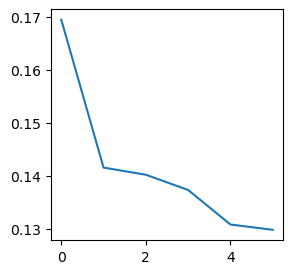

In [19]:
# Split into ~6 equal parts
speed_chunks = np.array_split(v, 6)
median_speeds = [np.median(chunk) for chunk in speed_chunks]
plt.figure(figsize=(3,3))
plt.plot(median_speeds)
plt.show()

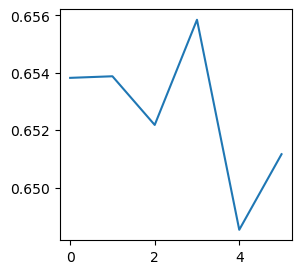

In [20]:
# Split into ~6 equal parts
y_chunks = np.array_split(y, 6)
median_y = [np.median(chunk) for chunk in y_chunks]
plt.figure(figsize=(3,3))
plt.plot(median_y)
plt.show()

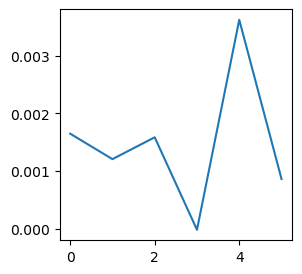

In [24]:
delta = 10 # frames/fs = sec; if 10 --> 0.083 sec = 83 ms
delta = 120 # i wanna 1 sec --> frames = t*120
delta_y = y[delta:] - y[:-delta]
delta_y_chunks = np.array_split(delta_y, 6)
median_delta_y = [np.median(chunk) for chunk in delta_y_chunks]
plt.figure(figsize=(3,3))
plt.plot(median_delta_y)
plt.show()